# Chest X-ray Classification using CNN

This project aims to classify chest X-rays as normal or abnormal using a convolutional neural network (CNN).

Dataset: NIH Chest X-ray dataset from Kaggle.

## 1. Import Libraries

In [30]:
import os
import shutil
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## 2. Configure Logging

In [15]:
# Keep track of progress and debug during training and preprocessing
logging.basicConfig(
    filename='training_log.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logging.info("Logging initialized successfully.")

## 3. Load Dataset

In [16]:
# Define separate paths for labels and images
labels_path = os.path.join("data", "archive", "Data_Entry_2017.csv")  # Path for CSV file
images_path = os.path.join("data", "images")  # Path for actual images

# Load the labels CSV file
logging.info(f"Loading labels from: {labels_path}")
df = pd.read_csv(labels_path)
logging.info("labels loaded successfully")

# Show first few rows of the dataset
print("Dataset Shape:", df.shape)
print(df.head())


Dataset Shape: (112120, 12)
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                      

## 4. Check for Missing Values

In [17]:
# Checking for any missing data to ensure data integrity.
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Image Index                         0
Finding Labels                      0
Follow-up #                         0
Patient ID                          0
Patient Age                         0
Patient Gender                      0
View Position                       0
OriginalImage[Width                 0
Height]                             0
OriginalImagePixelSpacing[x         0
y]                                  0
Unnamed: 11                    112120
dtype: int64


In [18]:
# Drop unnamed column
df = df.drop(columns=['Unnamed: 11'])
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
dtype: int64


## 5. Simplify Target Labels

In [19]:
# We simplify the multi-label classification to binary: Normal vs Abnormal
df['Target'] = df['Finding Labels'].apply(lambda x: 'Normal' if x == 'No Finding' else 'Abnormal')

## 6. Visualize Class Distribution

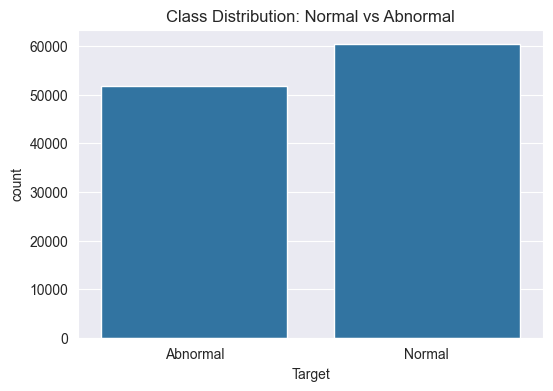

In [20]:
# Looking at class balance to detect potential imbalances in the data that might affect training
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Target')
plt.title("Class Distribution: Normal vs Abnormal")
plt.show()

## 7. Display Sample Images

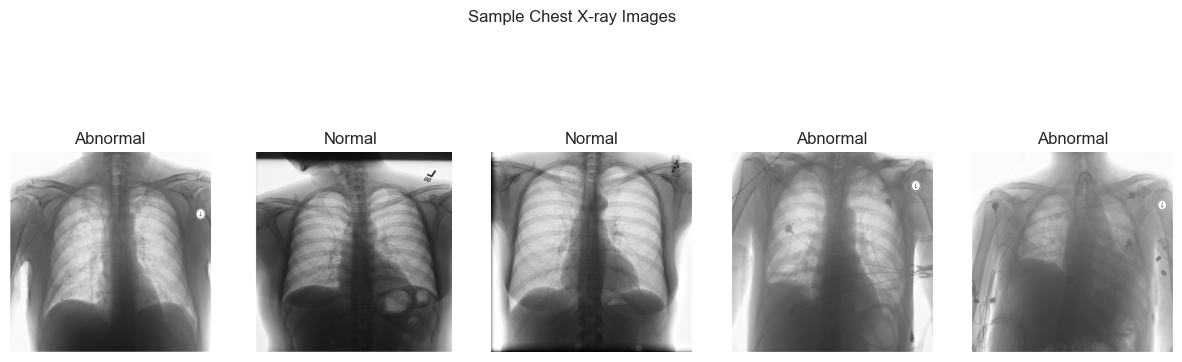

In [22]:
# Visualizing sample chest X-ray images to get an idea of the data quality and characteristics
sample_images = df.sample(5)
plt.figure(figsize=(15,5))
for i, row in enumerate(sample_images.iterrows()):
    img_path = os.path.join(images_path, row[1]['Image Index'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap='gray_r') # using gray_r to see X-rays un-inverted
    plt.title(row[1]['Target'])
    plt.axis('off')
plt.suptitle("Sample Chest X-ray Images")
plt.show()

## 8. Data Preprocessing
Before feeding images into the CNN, we need to do the following:
- Convert grayscale X-ray images to a standard format
- Resize images to a fixed size (128x128) for consistent input shape
- Normalize pixel values (0 to 1)
- Split dataset into Training and Testing sets to evaluate model performance

We will also be utilizing a data generator approach to save on RAM space

## 8. Organize Images by Folders

In [ ]:
# Move images into respective class folders to use with ImageDataGenerator

In [28]:
# Create directories if they don't exist
for split in ['train', 'test']:
    for label in ['Normal', 'Abnormal']:
        os.makedirs(os.path.join('data', split, label), exist_ok=True)

# Split dataset into train and test (80/20 split)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Target'], random_state=42)

# Move images
logging.info("Organizing images into folders...")

def move_images(subset_df, subset_name):
    for _, row in subset_df.iterrows():
        label = row['Target']
        src_path = os.path.join(images_path, row['Image Index'])
        dest_path = os.path.join('data', subset_name, label, row['Image Index'])
        if os.path.exists(src_path):
            shutil.copy2(src_path, dest_path)

move_images(train_df, 'train')
move_images(test_df, 'test')

logging.info("Images successfully organized into train and test folders.")

KeyboardInterrupt: 

In [31]:
print(tf.config.list_physical_devices('GPU'))


[]


In [23]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12572008437050781264
xla_global_id: -1
]


In [7]:
print("Training Set Distribution:")
print(train_df["label"].value_counts())

print("\nTesting Set Distribution:")
print(test_df["label"].value_counts())


Training Set Distribution:
label
0    48289
1    41407
Name: count, dtype: int64

Testing Set Distribution:
label
0    12072
1    10352
Name: count, dtype: int64


In [8]:
IMG_SIZE = 224

def load_and_preprocess_image(img_path):
    """Load an image, convert to grayscale, resize, and normalize it."""
    if not os.path.exists(img_path):
        logging.warning(f"Warning: Image not found at {img_path}")
        return np.zeros((IMG_SIZE, IMG_SIZE))  # Return a blank image to avoid crashing

    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image as grayscale
    if image is None:
        logging.warning(f"Warning: OpenCV failed to load image {img_path}")
        return np.zeros((IMG_SIZE, IMG_SIZE))  # Return a blank image

    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize to (224,224)
    image = image / 255.0  # Normalize pixel values to 0-1
    return image


In [9]:
def save_batches(df, images_path, batch_size=1000, save_dir='batches'):
    """Preprocess and save data in batches to disk."""
    os.makedirs(save_dir, exist_ok=True)
    image_paths = df["Image Index"].apply(lambda x: os.path.join(images_path, x)).values
    labels = df["label"].values

    batch_images, batch_labels = [], []
    batch_num = 0

    for i, (img_path, label) in enumerate(zip(image_paths, labels)):
        image = load_and_preprocess_image(img_path)
        if image is None:
            continue

        batch_images.append(image)
        batch_labels.append(label)

        # Save batch
        if (i + 1) % batch_size == 0 or (i + 1) == len(df):
            X = np.array(batch_images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
            y = np.array(batch_labels)
            np.save(os.path.join(save_dir, f'X_batch_{batch_num}.npy'), X)
            np.save(os.path.join(save_dir, f'y_batch_{batch_num}.npy'), y)
            logging.info(f"Saved batch {batch_num}")
            batch_images, batch_labels = [], []
            batch_num += 1

In [ ]:
save_batches(train_df, images_path, batch_size=1000, save_dir='batches')

In [10]:
def load_batch(batch_num, save_dir='batches'):
    """Load preprocessed batch from disk."""
    X = np.load(os.path.join(save_dir, f'X_batch_{batch_num}.npy'), mmap_mode='r')
    y = np.load(os.path.join(save_dir, f'y_batch_{batch_num}.npy'))
    return X, y

In [11]:
def create_cnn_model(input_shape):
    """Creates and returns a CNN model."""
    model = Sequential()
    model.add(Input(shape=input_shape))  # <-- Preferred way to set input shape
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [51]:
# Path to established model
model_path = os.path.join("saved_models", "cnn_chest_xray_model.keras")

# Training on established model or creating new model if none exists
if os.path.exists(model_path):
    logging.info("Loading existing model...")
    model = load_model(model_path)
else:
    logging.info("No existing model found, creating new model...")
    model = create_cnn_model((224, 224, 1))

# Count number of saved batches
num_batches = len([f for f in os.listdir('batches') if f.startswith('X_batch_')])

# Set number of epochs
epochs = 5

# Training loop with progress bar
for epoch in range(epochs):
    logging.info(f"\nEpoch {epoch + 1}/{epochs}")
    progress_bar = tqdm(range(num_batches), desc=f"Epoch {epoch + 1}", miniters=5)

    for batch_num in progress_bar:
        X_batch, y_batch = load_batch(batch_num)  # Your batch loading function
        history = model.fit(X_batch, y_batch, epochs=1, verbose=0)  # Train silently
        # Update progress bar with current loss and accuracy
        progress_bar.set_postfix({
            "loss": f"{history.history['loss'][0]:.4f}",
            "accuracy": f"{history.history['accuracy'][0]:.4f}"
        })
    logging.info(f"Epoch {epoch + 1} completed: Loss = {history.history['loss'][0]}, Accuracy = {history.history['accuracy'][0]}")

logging.info("\nTraining complete!")

Epoch 5: 100%|██████████| 90/90 [16:40<00:00, 11.12s/it, loss=0.4055, accuracy=0.8247]


In [52]:
# Save the trained model
model_path = os.path.join("saved_models", "cnn_chest_xray_model.keras")
model.save(model_path, overwrite=True)
logging.info("Model saved successfully!")

In [13]:
# Load the saved model
model_path = os.path.join("saved_models", "cnn_chest_xray_model.keras")
model = load_model(model_path)
logging.info("Model loaded successfully!")